# DRL Course 2023 Домашнее задание 7 #

Отчет по выполнению домашнего задания, Nikita Sorokin

In [7]:
import numpy as np
import random
import torch
import torch.nn as nn
import gym
import time
from tqdm import tqdm
from copy import deepcopy
from torch.distributions import Normal, Categorical

import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns

sns.set()

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 6.0)

In [15]:
def save_frames_as_gif(frames, path='./', filename='gym_animation.gif', fps=60):

    plt.figure(figsize=(frames[0].shape[1] / 50.0, frames[0].shape[0] / 50.0), dpi=72)

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
    anim.save(path + filename, writer='imagemagick', fps=fps)

## Сравнение алгоритмов для среды Pendulum-v1

In [12]:
env = gym.make('Pendulum-v1')

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

### CEM

Пусть $ \pi^{\theta}: \mathbb{R}^n \rightarrow \mathbb{R}^m $ - нейронная сеть.

В цикле по $ n $ для $ n \in \overline{1, N} $:

* **(Policy evaluation)** В соответствии с политикой

$$
\pi_n (s) = [\pi^{\theta_n} + Noise(\varepsilon)]_A,
$$

получим $ K $ траекторий $ \theta_k $ и награду $ G(\tau_k) $. Оценим матожидание как:

$$
\mathbb{E}_{\pi_n} [G] \approx V_n :=  \frac{1}{K} \sum_{k=1}^{K} G(\tau_k)
$$


* **(Policy improvement)** Выбираем элитные тракектории, как

$$  
T_n = \{\tau_k: k \in \overline{1, K}: G(\tau_k) > \gamma_q \}, \quad
\text{где $ \gamma_q $ - квантиль уровня $ q $}. 
$$

Определяем лосс:

$$
Loss(\theta) = \frac{1}{|T_n|} \sum_{(a|s) \in T_n} || \pi^{\theta_n} (s) - a||^2
$$

Обновляем $ \theta $ градиентным спуском и уменьшаем $ \varepsilon $.

Реализация:



In [312]:
class CEM_continuous(nn.Module):
    def __init__(self, state_dim, action_dim, min_action, max_action):
        super().__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.min_action = min_action
        self.max_action = max_action

        self.network = nn.Sequential(
            nn.Linear(self.state_dim, 100),
            nn.ReLU(),
            nn.Linear(100, self.action_dim)
        )

        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-1, betas=(0.9, 0.999))
        self.loss = nn.MSELoss()

    def forward(self, _input):
        return self.network(_input)

    def get_action(self, state, eps=0, discrete_action=False):
        state = torch.FloatTensor(state)
        self.min_action = torch.FloatTensor([self.min_action])
        self.max_action = torch.FloatTensor([self.max_action])

        noise = torch.randn(self.action_dim)
        noise = 2 if noise > 0 else -2

        with torch.no_grad():
            action = torch.clamp(self.forward(state) + eps * noise,
                                 min=self.min_action, max=self.max_action)
        action = action.detach().numpy()

        if discrete_action == True:
            action = list([2 if action > 0 else -2])

        return action

    def update_policy(self, elite_trajectories):
        elite_states = []
        elite_actions = []
        for trajectory in elite_trajectories:
            elite_states.extend(trajectory['states'])
            elite_actions.extend(trajectory['actions'])
        elite_states = torch.FloatTensor(elite_states)
        elite_actions = torch.FloatTensor(elite_actions)

        loss = self.loss(self.forward(elite_states), elite_actions)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

In [313]:
def get_trajectory(env, agent, trajectory_len, eps=0, visualize=False, filename='gym_animation.gif', discrete_action=False):
    trajectory = {'states':[], 'actions': [], 'total_reward': 0}

    state = env.reset()
    trajectory['states'].append(state)

    frames = []
    for i in range(trajectory_len):

        action = agent.get_action(state, eps, discrete_action)
        trajectory['actions'].append(action)

        state, reward, done, _ = env.step(action)
        trajectory['total_reward'] += reward

        if done:
            break

        if visualize:
            frames.append(env.render(mode="rgb_array"))

        if i != trajectory_len - 1:
            trajectory['states'].append(state)

    if visualize:
        save_frames_as_gif(frames, filename=filename)

    return trajectory

def get_elite_trajectories(trajectories, q_param):
    total_rewards = [trajectory['total_reward'] for trajectory in trajectories]
    quantile = np.quantile(total_rewards, q=q_param)
    return [trajectory for trajectory in trajectories if trajectory['total_reward'] > quantile]

In [314]:
def train(env, agent, episode_n, trajectory_n, trajectory_len, q_param, noise=False, autosave=False, discrete_action=False):
    mean_rewards = []
    all_rewards = []
    max_reward = -5000
    for episode in range(episode_n):

        eps = 0
        if noise == True:
            eps = 1 / np.sqrt(episode + 1)

        trajectories = [get_trajectory(env, agent, trajectory_len, eps, discrete_action=discrete_action) for _ in range(trajectory_n)]
        mean_total_reward = np.mean([trajectory['total_reward'] for trajectory in trajectories])

        if autosave == True:
            if mean_total_reward < max_reward:
                continue
        max_reward = mean_total_reward

        all_rewards.extend([trajectory['total_reward'] for trajectory in trajectories])
        mean_rewards.append(mean_total_reward)
        print(f'episode: {episode}, mean_total_reward = {mean_total_reward}')

        elite_trajectories = get_elite_trajectories(trajectories, q_param)
        if len(elite_trajectories) > 0:
            agent.update_policy(elite_trajectories)

    return all_rewards, mean_rewards

In [315]:
def validation(env, agent, validation_n=100, trajectory_len=200):
    rewards = []
    for i in range(validation_n):
        trajectory = get_trajectory(env, agent, trajectory_len, visualize=False, discrete_action=True)
        rewards.append(trajectory['total_reward'])

    return np.mean(rewards)

Обучение: (30 минут)

Подобранные гиперпараметры:


```python
episode_n = 125
trajectory_n = 100
trajectory_len = 200
q_param = 0.8

agent.optimizer = torch.optim.Adam(agent.parameters(), lr=1e-1)
```

При обучении разрешаем всего 2 действия 2 и -2 из всего отрезка действий [-2, 2]. Это ограничение позволяет маятнику научиться уверенно раскачиваться. За эту функцию отвечает условие discrete_action = True.

**Замечание:** При выполнении дз 2 обучение проходило в 3 этапа:

1. Учимся с большим количеством шума, причем разрешаем всего 2 действия 2 и -2 из всего отрезка действий [-2, 2]. Это ограничение позволяет маятнику научиться уверенно раскачиваться. За эту функцию отвечает условие discrete_action = True.

2. Оставляем шум, возвращаем возможность выполнять все действия в отрезке [-2, 2]. Этот этап позволяет научиться маятнику выбирать действия, когда он проходит положение неустойчивого равновесия наверху.

3. Убираем шум, разрешаем действия 2 и -2. К тому же теперь используем условие autosave = True, которое не позволяет модели учиться если mean_total_reward полученный в текущем эпизоде меньше предыдущего. Этот этап позволяет уверенно управлять маятником, когда тот находится наверху и пытается устоять.

Но для честности сравнения алгоритмов обучение проводится в 1 этап: 

1. Действия разрешается всего 2 штуки: 2 и -2. Размеренное использование шума $ \varepsilon(n) = 1 / \sqrt{n + 1} $. 

In [316]:
min_action, max_action = -2, 2

In [317]:
agent = CEM_continuous(state_dim, action_dim, min_action, max_action)

In [318]:
episode_n = 125
trajectory_n = 100
trajectory_len = 200
q_param = 0.8

agent.optimizer = torch.optim.Adam(agent.parameters(), lr=1e-1)

In [319]:
history = []
mean_rewards_history = []

In [ ]:
new_history, new_mean_rewards_history = train(env, agent, episode_n, trajectory_n, trajectory_len, q_param, discrete_action=True)

In [ ]:
history.extend(new_history)
mean_rewards_history.extend(new_mean_rewards_history)

График обучения:

In [326]:
history = np.load('cem_pendulum_mean_rewards_history.npy')
history = history[:125]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


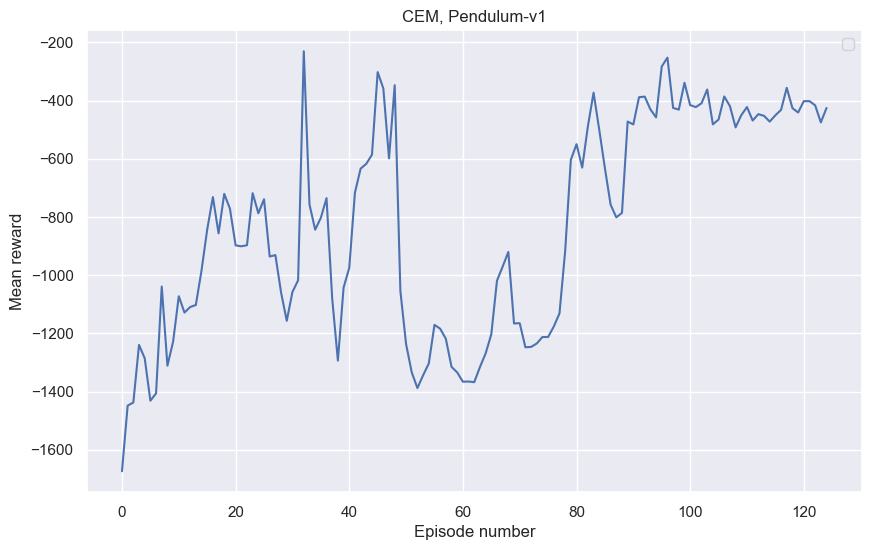

In [328]:
plt.title('CEM, Pendulum-v1')
plt.xlabel('Episode number')
plt.ylabel('Mean reward')
plt.legend()

plt.plot(history)

Валидация:

In [ ]:
val_score = validation(env, agent)
print(f'mean total reward on 100 validation trajectories: {val_score}')

mean total reward on 100 validation trajectories: -441.301006123251


Из-за длительности обучения и нестабильности ограничимся только этим результатом:

Использую экспоненциальное сглаживание, преобразуем график истории обучения

In [344]:
h1 = np.load('cem_pendulum_history.npy')
h2 = np.load('cem_pendulum_history2.npy')

In [345]:
h1 = h1[:h2.size]

In [352]:
def get_plots(h1):

    h_smoothed1 = np.zeros_like(h1)

    alpha = 0.1
    h_smoothed1[0] = h1[0]

    for i in range(1, h_smoothed1.size):
        h_smoothed1[i] = alpha * h1[i] + (1 - alpha) * h_smoothed1[i - 1]

    h_smoothed1 = h_smoothed1.reshape(-1, 1)

    plt.plot(np.arange(h_smoothed1.size), h_smoothed1)

    plt.title('CEM, Pendulum-v1')
    plt.xlabel('Trajectory number')
    plt.ylabel('Trajectory reward')
    plt.legend()

    return h_smoothed1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


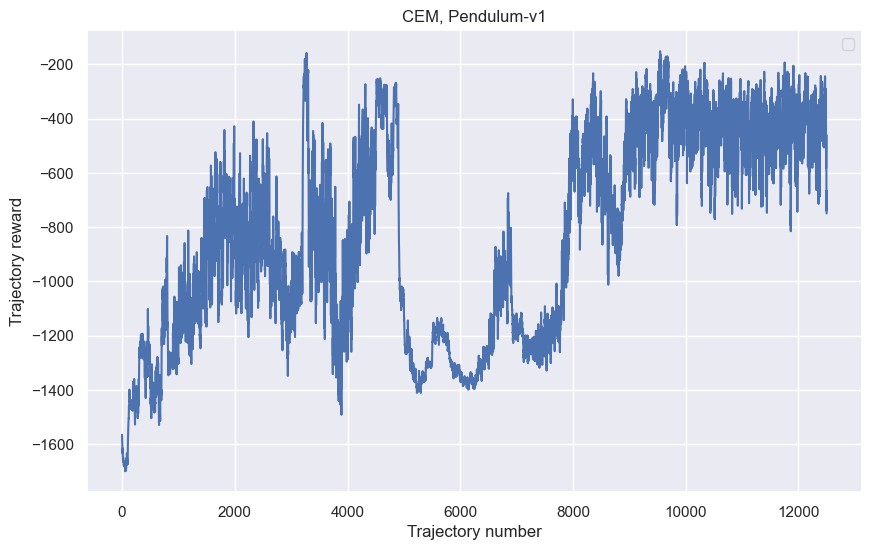

In [353]:
cem_history_smoothed = get_plots(h1)

При меньшем коэффиценте сглаживания награда в конце становится еще меньше. Поэтому ограничимся таким уровнем сглаживания.

### PPO


Задаем структуру аппроксимации $Q^\theta$, начальные вектор параметров $\theta$, вероятность исследования среды $\varepsilon = 1$.

Для каждого эпизода $k$ делаем:

Пока эпизод не закончен делаем:

- Находясь в состоянии $S_t$ совершаем действие $A_t \sim \pi(\cdot|S_t)$, где $\pi = \varepsilon\text{-greedy}(Q^\theta)$, получаем награду $R_t$  переходим в состояние $S_{t+1}$. Сохраняем $(S_t,A_t,R_t,S_{t+1}) \rightarrow Memory$


- Берем $\{(s_i,a_i,r_i,s'_i)\}_{i=1}^{n} \leftarrow Memory$, определяем целевые значения

$$
y_i =
\left\{
\begin{array}{ll}
r_i, &\text{ если } s'_i\text{ -терминальное},\\[0.0cm]
 r_i + \gamma \max\limits_{a'} Q^\theta(s'_i,a'), &\text{ иначе}
\end{array}
\right.
$$

функцию потерь $Loss(\theta) = \frac{1}{n}\sum\limits_{i=1}^n \big(y_i - Q^\theta(s_i,a_i)\big)^2$
и обновляем вектор параметров

$$
\theta \leftarrow \theta - \alpha \nabla_\theta Loss(\theta)
$$

- Уменьшаем $\varepsilon$


Реализация:

In [265]:
class PPO(nn.Module):
    def __init__(self, state_dim, action_dim, gamma=0.9, batch_size=128, 
                 epsilon=0.2, epoch_n=30, pi_lr=1e-4, v_lr=5e-4):

        super().__init__()
        
        self.state_dim = state_dim
        self.action_dim = action_dim

        self.pi_model = nn.Sequential(nn.Linear(self.state_dim, 128), nn.ReLU(),
                                      nn.Linear(128, 128), nn.ReLU(),
                                      nn.Linear(128, 2 * self.action_dim), nn.Tanh())
        
        self.v_model = nn.Sequential(nn.Linear(self.state_dim, 128), nn.ReLU(),
                                     nn.Linear(128, 128), nn.ReLU(),
                                     nn.Linear(128, 1))
        
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.epoch_n = epoch_n
        self.pi_optimizer = torch.optim.Adam(self.pi_model.parameters(), lr=pi_lr)
        self.v_optimizer = torch.optim.Adam(self.v_model.parameters(), lr=v_lr)

    def get_action(self, state):
        mean, log_std = self.pi_model(torch.FloatTensor(state))
        dist = Normal(mean, torch.exp(log_std))
        action = dist.sample()
        return action.numpy().reshape(1)

    def fit(self, states, actions, rewards, dones, advantage='default'):
        
        states, actions, rewards, dones = map(np.array, [states, actions, rewards, dones])
        rewards, dones = rewards.reshape(-1, 1), dones.reshape(-1, 1)

        next_states = np.zeros_like(states)
        next_states[:-1] = states[1:]

        returns = np.zeros(rewards.shape)
        returns[-1] = rewards[-1]
        for t in range(returns.shape[0] - 2, -1, -1):
            returns[t] = rewards[t] + (1 - dones[t]) * self.gamma * returns[t + 1]

        states, next_states, actions, rewards, returns, dones = map(torch.FloatTensor, [states, next_states, actions, rewards, returns, dones])

        mean, log_std = self.pi_model(states).T
        mean, log_std = mean.unsqueeze(1), log_std.unsqueeze(1)
        dist = Normal(mean, torch.exp(log_std))
        old_log_probs = dist.log_prob(actions).detach()

        for epoch in range(self.epoch_n):
            
            idxs = np.random.permutation(returns.shape[0])
            for i in range(0, returns.shape[0], self.batch_size):
                b_idxs = idxs[i: i + self.batch_size]
                b_states = states[b_idxs]
                b_next_states = next_states[b_idxs]
                b_dones = dones[b_idxs]
                b_actions = actions[b_idxs]
                b_rewards = rewards[b_idxs]
                b_returns = returns[b_idxs]
                b_old_log_probs = old_log_probs[b_idxs]

                if advantage == 'default':
                    b_advantage = b_returns.detach() - self.v_model(b_states)

                if advantage == 'bellman':
                    b_advantage = b_rewards.detach() + (1 - b_dones.detach()) * self.gamma * self.v_model(b_next_states.detach()) - self.v_model(b_states) 

                if advantage == 'test':
                    b_advantage = b_rewards.detach() + (1 - b_dones.detach()) * self.gamma * self.v_model(b_next_states) - self.v_model(b_states) 

                b_mean, b_log_std = self.pi_model(b_states).T
                b_mean, b_log_std = b_mean.unsqueeze(1), b_log_std.unsqueeze(1)
                b_dist = Normal(b_mean, torch.exp(b_log_std))
                b_new_log_probs = b_dist.log_prob(b_actions)
    
                b_ratio = torch.exp(b_new_log_probs - b_old_log_probs)
                pi_loss_1 = b_ratio * b_advantage.detach()
                pi_loss_2 = torch.clamp(b_ratio, 1. - self.epsilon,  1. + self.epsilon) * b_advantage.detach()
                pi_loss = - torch.mean(torch.min(pi_loss_1, pi_loss_2))
                
                pi_loss.backward()
                self.pi_optimizer.step()
                self.pi_optimizer.zero_grad()
                
                v_loss = torch.mean(b_advantage ** 2)
    
                v_loss.backward()
                self.v_optimizer.step()
                self.v_optimizer.zero_grad()

In [266]:
def get_trajectory(env, agent, trajectory_len=200, visualize=False, filename='gym_animation.gif'):
    trajectory = {'states':[], 'actions': [], 'rewards': [], 'dones': []}
    
    state = env.reset()

    frames = []
    for _ in range(trajectory_len):

        trajectory['states'].append(state)

        action = agent.get_action(state)
        trajectory['actions'].append(action)

        next_state, reward, done, _ = env.step(2 * action)
        trajectory['rewards'].append(reward)
        trajectory['dones'].append(done)

        state = next_state

        if done:
            break

        if visualize:
            frames.append(env.render(mode="rgb_array"))

    if visualize:
        save_frames_as_gif(frames, filename=filename)

    return trajectory

In [267]:
def train(env, agent, episode_n=50, trajectory_n=20, trajectory_len=200, advantage='default'):
    total_rewards = []
    for episode in range(episode_n):

        states, actions, rewards, dones = [], [], [], []

        for i in range(trajectory_n):

            trajectory = get_trajectory(env, agent, trajectory_len)

            states.extend(trajectory['states'])
            actions.extend(trajectory['actions'])
            rewards.extend(trajectory['rewards'])
            dones.extend(trajectory['dones'])

            total_rewards.append(np.sum(trajectory['rewards']))

        print(f"{episode}: mean reward = {np.mean(total_rewards[-trajectory_n:])}")

        agent.fit(states, actions, rewards, dones, advantage)

    return total_rewards

In [268]:
def validation(env, agent, validation_n, trajectory_len=200):
    total_rewards = []
    for _ in range(validation_n):
        trajectory = get_trajectory(env, agent, trajectory_len)
        total_rewards.append(np.sum(trajectory['rewards']))

    return np.mean(total_rewards)

Обучение: (4 мин)

Для обучения были подобраны следующие гиперпараметры:

```python
episode_n = 50
trajectory_n = 20

gamma = 0.9
batch_size = 128 
epsilon = 0.2
epoch_n = 30 
pi_lr = 1e-4 
v_lr = 5e-4
```

In [269]:
ppo_default_agent = PPO(state_dim, action_dim)

In [270]:
episode_n = 25
trajectory_n = 20

In [271]:
ppo_default_history = []

In [272]:
ppo_default_rewards = train(env, ppo_default_agent, episode_n, trajectory_n, advantage='default')

0: mean reward = -1278.0783112013814
1: mean reward = -1243.1860322919997
2: mean reward = -1079.2787898393588
3: mean reward = -1080.0475041417526
4: mean reward = -1029.7964957888144
5: mean reward = -989.8740726824068
6: mean reward = -866.1873529993679
7: mean reward = -811.8428887288536
8: mean reward = -711.3382139367643
9: mean reward = -575.3244306962114
10: mean reward = -425.0184104726859
11: mean reward = -275.0689094802138
12: mean reward = -176.25182731499638
13: mean reward = -315.9776533929087
14: mean reward = -241.64287070850077
15: mean reward = -258.6925880716366
16: mean reward = -233.75410757706763
17: mean reward = -220.13377354685926
18: mean reward = -198.92716738803466
19: mean reward = -237.52572003654123
20: mean reward = -230.16229091986975
21: mean reward = -215.4226321066843
22: mean reward = -231.15860624776946
23: mean reward = -170.7798852226661
24: mean reward = -243.91879849125112


In [273]:
ppo_default_history.extend(ppo_default_rewards)

График обучения:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


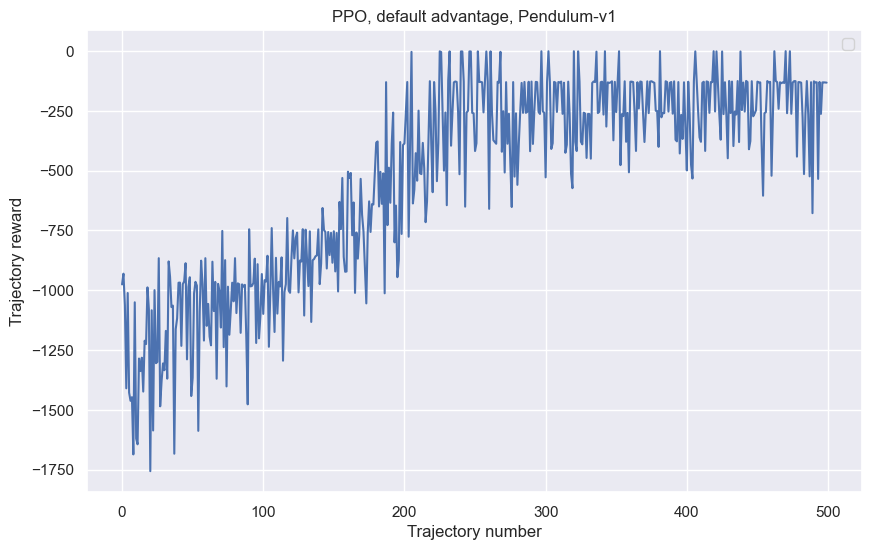

In [275]:
plt.title('PPO, default advantage, Pendulum-v1')
plt.xlabel('Trajectory number')
plt.ylabel('Trajectory reward')
plt.legend()

plt.plot(ppo_default_history)

Валидация

In [279]:
validation_n = 100

validation_score = validation(env, ppo_default_agent, validation_n=validation_n, trajectory_len=200)
print(f'PPO, default advantage, validation_score: {validation_score}')

PPO, default advantage, validation_score: -252.77200815790158


Повторим еще 2 раза и построим сглаженный график:

In [378]:
h1 = np.load('ppo_default_history1.npy')
h2 = np.load('ppo_default_history2.npy')
h3 = np.load('ppo_default_history3.npy')

In [379]:
def get_plots(h1, h2, h3):

    h_smoothed1 = np.zeros_like(h1)
    h_smoothed2 = np.zeros_like(h1)
    h_smoothed3 = np.zeros_like(h1)

    alpha = 0.1
    h_smoothed1[0] = h1[0]
    h_smoothed2[0] = h2[0]
    h_smoothed3[0] = h3[0]

    for i in range(1, h_smoothed1.size):
        h_smoothed1[i] = alpha * h1[i] + (1 - alpha) * h_smoothed1[i - 1]
        h_smoothed2[i] = alpha * h2[i] + (1 - alpha) * h_smoothed2[i - 1]
        h_smoothed3[i] = alpha * h3[i] + (1 - alpha) * h_smoothed3[i - 1]


    h_smoothed1 = h_smoothed1.reshape(-1, 1)
    h_smoothed2 = h_smoothed2.reshape(-1, 1)
    h_smoothed3 = h_smoothed3.reshape(-1, 1)

    h_smoothed = np.concatenate((h_smoothed1, h_smoothed2, h_smoothed3), axis=1)
    h_smoothed_mean = np.mean(h_smoothed, axis=1)
    stds = np.std(h_smoothed, axis=1)

    plt.plot(np.arange(h_smoothed_mean.size), h_smoothed_mean)
    plt.fill_between(np.arange(h_smoothed_mean.size), h_smoothed_mean - stds, h_smoothed_mean + stds, alpha=0.5)

    plt.title('PPO, default advantage, Pendulum-v1')
    plt.xlabel('Trajectory number')
    plt.ylabel('Trajectory reward')
    plt.legend()

    return h_smoothed_mean, stds

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


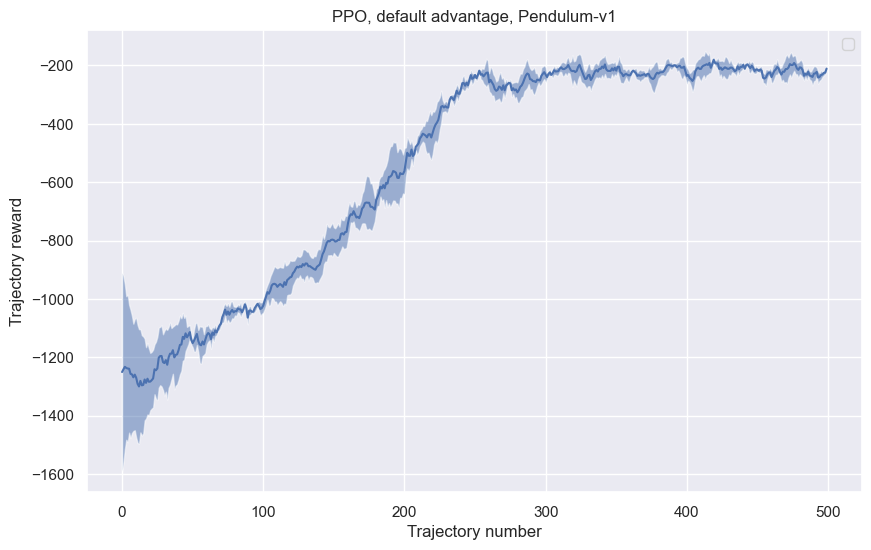

In [380]:
ppo_history_smoothed, ppo_std_smoothed = get_plots(h1, h2, h3)

### SAC

Реализация:

In [ ]:
class SAC(nn.Module):
    def __init__(self, state_dim, action_dim, gamma=0.99, alpha=1e-3, tau=1e-2, 
                 batch_size=64, pi_lr=1e-3, q_lr=1e-3):
        super().__init__()

        self.pi_model = nn.Sequential(nn.Linear(state_dim, 128), nn.ReLU(), 
                                      nn.Linear(128, 128), nn.ReLU(), 
                                      nn.Linear(128, 2 * action_dim), nn.Tanh())

        self.q1_model = nn.Sequential(nn.Linear(state_dim + action_dim, 128), nn.ReLU(), 
                                      nn.Linear(128, 128), nn.ReLU(), 
                                      nn.Linear(128, 1))

        self.q2_model = nn.Sequential(nn.Linear(state_dim + action_dim, 128), nn.ReLU(), 
                                      nn.Linear(128, 128), nn.ReLU(), 
                                      nn.Linear(128, 1))

        self.gamma = gamma
        self.alpha = alpha
        self.tau = tau
        self.batch_size = batch_size
        self.memory = []

        self.softmax = nn.Softmax()

        self.pi_optimizer = torch.optim.Adam(self.pi_model.parameters(), pi_lr)
        self.q1_optimizer = torch.optim.Adam(self.q1_model.parameters(), q_lr)
        self.q2_optimizer = torch.optim.Adam(self.q2_model.parameters(), q_lr)

        self.q1_target_model = deepcopy(self.q1_model)
        self.q2_target_model = deepcopy(self.q2_model)


    def get_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        action, _ = self.predict_actions(state)
        return action.squeeze(1).detach().numpy()


    def fit(self, state, action, reward, done, next_state):
        self.memory.append([state, action, reward, done, next_state])

        if len(self.memory) > self.batch_size:
            batch = random.sample(self.memory, self.batch_size)
            states, actions, rewards, dones, next_states = map(torch.FloatTensor, zip(*batch))
            rewards, dones = rewards.unsqueeze(1), dones.unsqueeze(1)

            next_actions, next_log_probs = self.predict_actions(next_states)
            
            next_states_and_actions = torch.concatenate((next_states, next_actions), dim=1)
            next_q1_values = self.q1_target_model(next_states_and_actions)
            next_q2_values = self.q2_target_model(next_states_and_actions)
            next_min_q_values = torch.min(next_q1_values, next_q2_values)
            targets = rewards + self.gamma * (1 - dones) * (next_min_q_values - self.alpha * next_log_probs)

            states_and_actions = torch.concatenate((states, actions), dim=1)
            q1_loss = torch.mean((self.q1_model(states_and_actions) - targets.detach()) ** 2)
            q2_loss = torch.mean((self.q2_model(states_and_actions) - targets.detach()) ** 2)
            self.update_model(q1_loss, self.q1_optimizer, self.q1_model, self.q1_target_model)
            self.update_model(q2_loss, self.q2_optimizer, self.q2_model, self.q2_target_model)

            pred_actions, log_probs = self.predict_actions(states)
            states_and_pred_actions = torch.concatenate((states, pred_actions), dim=1)
            q1_values = self.q1_model(states_and_pred_actions)
            q2_values = self.q2_model(states_and_pred_actions)
            min_q_values = torch.min(q1_values, q2_values)
            pi_loss = - torch.mean(min_q_values - self.alpha * log_probs)
            self.update_model(pi_loss, self.pi_optimizer)
            
    def update_model(self, loss, optimizer, model=None, target_model=None):
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if model != None and target_model != None:
            for param, terget_param in zip(model.parameters(), target_model.parameters()):
                new_terget_param = (1 - self.tau) * terget_param + self.tau * param
                terget_param.data.copy_(new_terget_param)

    def predict_actions(self, states):
        means, log_stds = self.pi_model(states).T
        means, log_stds = means.unsqueeze(1), log_stds.unsqueeze(1)
        dists = Normal(means, torch.exp(log_stds))
        actions = dists.rsample()
        log_probs = dists.log_prob(actions)

        return actions, log_probs

In [ ]:
def get_trajectory(env, agent, trajectory_len=200, visualize=False, filename='gym_animation.gif'):
    trajectory = {'states':[], 'actions': [], 'rewards': [], 'dones': []}
    
    state = env.reset()

    frames = []
    for _ in range(trajectory_len):

        trajectory['states'].append(state)

        action = agent.get_action(state)
        trajectory['actions'].append(action)

        next_state, reward, done, _ = env.step(action)
        trajectory['rewards'].append(reward)
        trajectory['dones'].append(done)

        state = next_state

        if done:
            break

        if visualize:
            frames.append(env.render(mode="rgb_array"))

    if visualize:
        save_frames_as_gif(frames, filename=filename)

    return trajectory

In [ ]:
def validation(env, agent, validation_n, trajectory_len=200):
    total_rewards = []
    for _ in range(validation_n):
        trajectory = get_trajectory(env, agent, trajectory_len)
        total_rewards.append(np.sum(trajectory['rewards']))

    return np.mean(total_rewards)

In [ ]:
def train(env, agent, episode_n, trajectory_len=200):
    total_rewards = []
    for episode in range(episode_n):

        total_reward = 0
        state = env.reset()
        
        for t in range(trajectory_len):
            action = agent.get_action(state)
            next_state, reward, done, _ = env.step(action)
        
            agent.fit(state, action, reward, done, next_state)

            total_reward += reward
            state = next_state

        total_rewards.append(total_reward)

    return total_rewards

Обучение: (6 мин)

Выбранные гиперпараметры:

```python
episode_n = 25

gamma=0.99 
alpha=1e-3
tau=1e-2
batch_size=64
pi_lr=1e-3
q_lr=1e-3
```

In [ ]:
agent = SAC(state_dim, action_n)

In [ ]:
episode_n = 200

In [ ]:
sac_history = train(env, agent, episode_n)

График обучения:

In [369]:
sac_history = np.load('sac_history3.npy')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


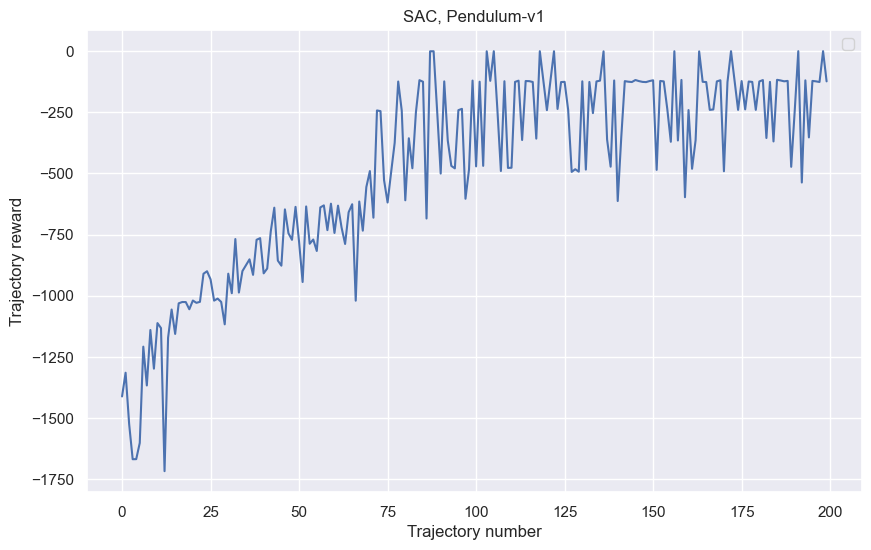

In [370]:
plt.title('SAC, Pendulum-v1')
plt.xlabel('Trajectory number')
plt.ylabel('Trajectory reward')
plt.legend()

plt.plot(sac_history)

Валидация:

**SAC, validation_score: -235.55826693948117**

In [ ]:
validation_n = 100

validation_score = validation(env, agent, validation_n=validation_n, trajectory_len=200)
print(f'SAC, default advantage, validation_score: {validation_score}')

Повторим еще 2 раза и построим сглаженный график:

In [371]:
h1 = np.load('sac_history1.npy')
h2 = np.load('sac_history2.npy')
h3 = np.load('sac_history3.npy')

In [372]:
def get_plots(h1, h2, h3):

    h_smoothed1 = np.zeros_like(h1)
    h_smoothed2 = np.zeros_like(h1)
    h_smoothed3 = np.zeros_like(h1)

    alpha = 1
    h_smoothed1[0] = h1[0]
    h_smoothed2[0] = h2[0]
    h_smoothed3[0] = h3[0]

    for i in range(1, h_smoothed1.size):
        h_smoothed1[i] = alpha * h1[i] + (1 - alpha) * h_smoothed1[i - 1]
        h_smoothed2[i] = alpha * h2[i] + (1 - alpha) * h_smoothed2[i - 1]
        h_smoothed3[i] = alpha * h3[i] + (1 - alpha) * h_smoothed3[i - 1]

    h_smoothed1 = h_smoothed1.reshape(-1, 1)
    h_smoothed2 = h_smoothed2.reshape(-1, 1)
    h_smoothed3 = h_smoothed3.reshape(-1, 1)

    h_smoothed = np.concatenate((h_smoothed1, h_smoothed2, h_smoothed3), axis=1)
    h_smoothed_mean = np.mean(h_smoothed, axis=1)
    stds = np.std(h_smoothed, axis=1)

    plt.plot(np.arange(h_smoothed_mean.size), h_smoothed_mean)
    plt.fill_between(np.arange(h_smoothed_mean.size), h_smoothed_mean - stds, h_smoothed_mean + stds, alpha=0.5)

    plt.title('SAC, Pendulum-v1')
    plt.xlabel('Trajectory number')
    plt.ylabel('Trajectory reward')
    plt.legend()

    return h_smoothed_mean, stds

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


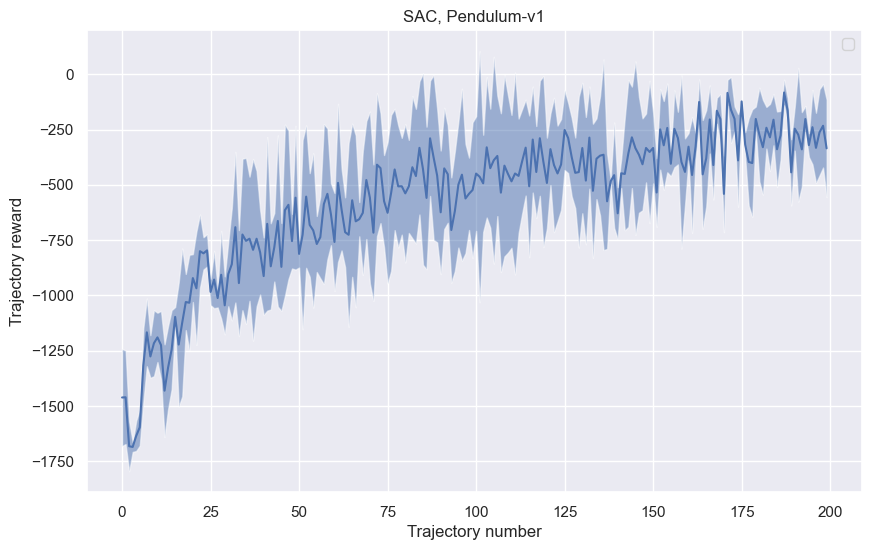

In [374]:
sac_history_smoothed, sac_std_smoothed = get_plots(h1, h2, h3)

## Полученные результаты:

Уже понятно, что CEM использует сильно больше траекторий. Изобразим кривые обучения PPO и SAC на одном графике:

In [384]:
def plot_results():

    plt.plot(np.arange(ppo_history_smoothed.size), ppo_history_smoothed, label='PPO')
    plt.fill_between(np.arange(ppo_history_smoothed.size),
                     ppo_history_smoothed - ppo_std_smoothed, 
                     ppo_history_smoothed + ppo_std_smoothed, alpha=0.4)

    plt.plot(np.arange(sac_history_smoothed.size), sac_history_smoothed, label='SAC')
    plt.fill_between(np.arange(sac_history_smoothed.size),
                     sac_history_smoothed - sac_std_smoothed, 
                     sac_history_smoothed + sac_std_smoothed, alpha=0.4)


    plt.title('Algorithm comparison, Pendulum-v1')
    plt.xlabel('Trajectory number')
    plt.ylabel('Trajectory reward')
    plt.legend()

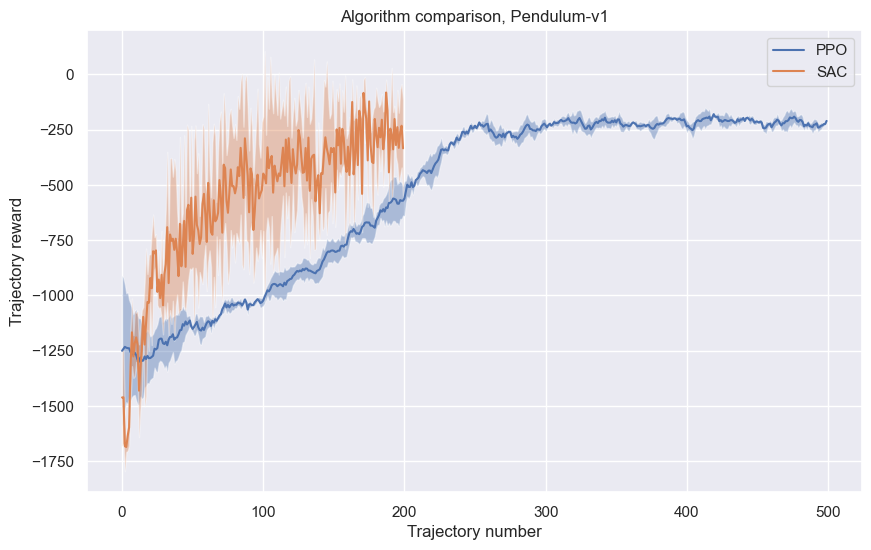

In [385]:
plot_results()

### **Вывод:**

Наилучшим алгоритмом по времени для обучения агента среды Pendulum-v1 оказался PPO. По количеству сгенерированных траекторий более успешным оказался SAC. Однако, как показывает практика, даже без теоретического аппарата $ Q $-функций и Policy Gradient теорем агента для данной среды можно обучить и эволюционным алгоритмом CEM.